# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [87]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [22]:
# dataframe with number of articles interactions per user
user_article = df.groupby('email')['article_id'].count()

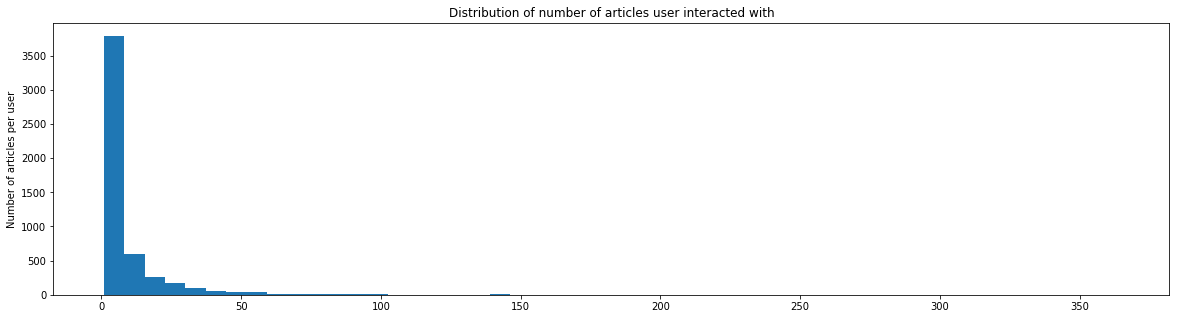

In [25]:
# plot histogram for ditribution of number of articles user interacted with

plt.hist(user_article.values, bins=50)
plt.ylabel('Number of articles per user')
plt.title('Distribution of number of articles user interacted with')

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.show()

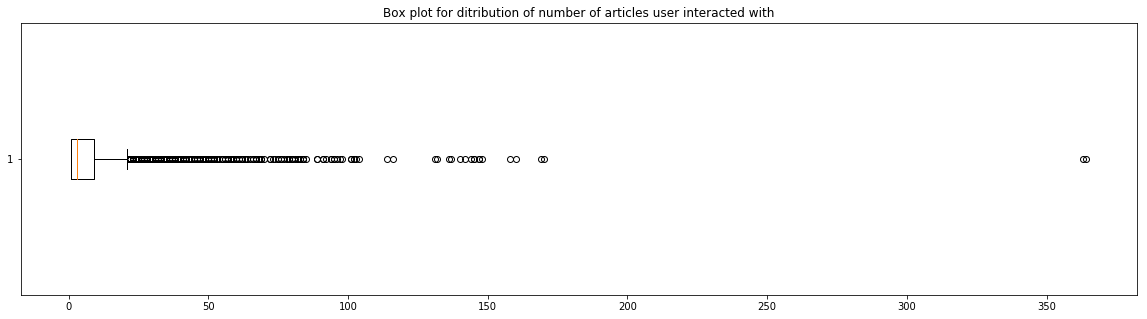

In [30]:
# plot box plot for ditribution of number of articles user interacted with

fig, ax = plt.subplots()
ax.set_title('Box plot for ditribution of number of articles user interacted with')
ax.boxplot(user_article.values, vert=False)

plt.show()

In [42]:
# average value of user iteractions

mean_articles = user_article.mean()

print('Average value of interactions with articles per user is {:.2f}'.format(mean_articles))

Average value of interactions with articles per user is 8.93


In [43]:
min_articles = user_article.min()

print('Minimum value of interactions with articles per user is {:d}'.format(min_articles))

Minimum value of interactions with articles per user is 1


In [44]:
max_articles = user_article.max()

print('Maximum value of interactions with articles per user is {:d}'.format(max_articles))

Maximum value of interactions with articles per user is 364


In [45]:
# median value of user iteractions

median_articles = user_article.median()

print('Median value of interactions with articles per user is {:.2f}'.format(median_articles))

Median value of interactions with articles per user is 3.00


In [56]:
# Fill in the median and maximum number of user_article interactios below

median_val = median_articles # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = max_articles # The maximum number of user-article interactions by any 1 user is 364.

print('50% of individuals interact with {:.2f} number of articles or fewer.'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {:d}.'.format(max_views_by_user))

50% of individuals interact with 3.00 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [88]:
# Find and explore duplicate articles

#Print rows with duplicated article_id
df_content[df_content.duplicated('article_id')== True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [89]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content.drop_duplicates('article_id')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [55]:
# number of unique articles that have an interaction with a user
len(df['article_id'].unique())

714

In [59]:
# number of unique articles on the IBM platform
df_content['article_id'].count()

1051

In [93]:
# number of unique users
df_new = df.dropna(subset = ['email']) #remove null users
len(df_new['email'].unique())

5148

In [94]:
# number of user-article interactions
df.shape[0]

45993

In [95]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [96]:
# dataframe with number of users iteracted with each article

article_user = df.groupby('article_id')['email'].count()

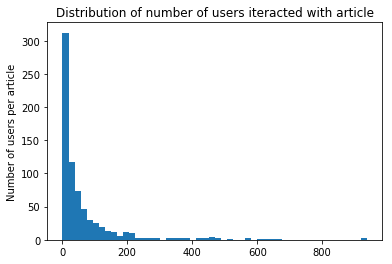

In [97]:
# plot histogram for ditribution of number of users iteracted with each article

plt.hist(article_user.values, bins=50)
plt.ylabel('Number of users per article')
plt.title('Distribution of number of users iteracted with article')

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 20
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.show()

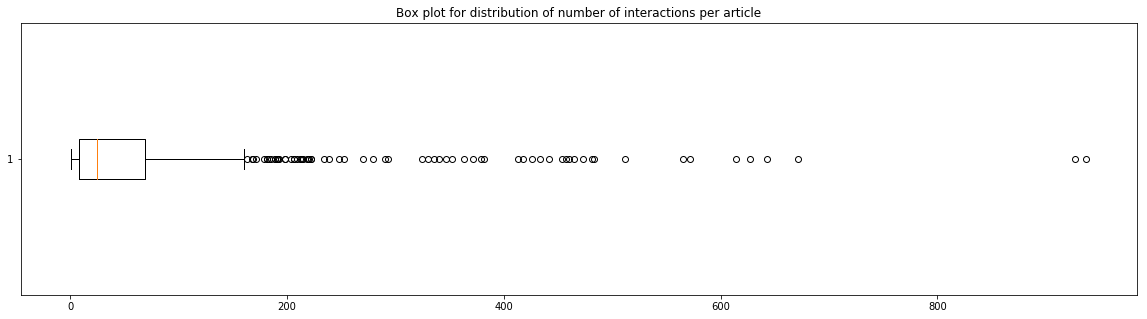

In [103]:
# plot box plot for distribution of number of interactions per article

fig, ax = plt.subplots()
ax.set_title('Box plot for distribution of number of interactions per article')
ax.boxplot(article_user.values, vert=False)

plt.show()

In [98]:
# The most viewed article in the dataset was viewed how many times?
article_user.max()

937

In [99]:
# The most viewed article in the dataset as a string with one value following the decimal 
article_user[article_user == 937].index[0]

1429.0

In [100]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [101]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [102]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [336]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count number of iteractions for each article_id
    article_user = df.groupby('article_id')['user_id'].count()
    
    # Sort articles by number of iteractions
    article_user = article_user.sort_values(ascending = False)
    
    # Get top-n article ids
    top_n = article_user.iloc[:n].index
    
    # Get article titles for top-n article ids
    top_articles = df[df['article_id'].isin(top_n)]['title'].unique()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Count number of iteractions for each article_id
    article_user = df.groupby('article_id')['user_id'].count()
    
    # Sort articles by number of iteractions
    article_user = article_user.sort_values(ascending = False)
    
    # Get top-n article ids
    top_articles = article_user.iloc[:n].index
    top_articles = top_articles.astype(str)
 
    return top_articles # Return the top article ids

In [337]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
       '1170.0', '1162.0', '1304.0'],
      dtype='object', name='article_id')


In [127]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [132]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Copy df dataframe and create a dummy column
    user_item = df.copy()
    user_item['cnt'] = 1
    
    # Create matrix with users in rows and articles in columns, if user interacted with article - 1 where
    # user row meets article column and NaN if user didn't interact with the article
    user_item = user_item.groupby(['user_id', 'article_id'])['cnt'].max().unstack()

    # Turn NaN into 0 where there was no interaction between user and article
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [133]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [252]:
def find_similar_users_similarity(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users_df - (pandas dataframe) where the closest users (largest dot product users)
                    are listed first which contains user id in neighbor_id column and similarity in 'similarity'
                    column
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_articles = np.array(user_item)
    dot_prod_users = user_articles.dot(np.transpose(user_articles))[user_id - 1]
    similarity = pd.DataFrame({'neighbor_id':user_item.index,'similarity':dot_prod_users})

    # sort by similarity
    similar_users_df = similarity.sort_values('similarity', ascending = False)
   
    # remove the own user's id
    similar_users_df = similar_users_df.drop(similar_users_df[similar_users_df.neighbor_id == user_id].index)
       
    return similar_users_df # return a dataframe with user ids and similarity to the user with specified user_id

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
   
    # obtain dataframe of users sorted by similarity and their
    most_similar_users = find_similar_users_similarity(user_id, user_item)['neighbor_id'].values
       
    return most_similar_users # return a list of the users in order from most to least similar

In [253]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are: [   1   23 3782  203 4459]
The 3 most similar users to user 46 are: [4201 3782   23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [350]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # find article_ids user interacted with
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    
    #find article names for articles user interacted with
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # get similar users
    similar_users = find_similar_users(user_id)
    
    # get articles user already interacted with
    user_articles = get_user_articles(user_id)[0]
    
    recs = []
    
    # loop through similar users
    for similar_user in similar_users:
        # find articles for each user
        recommended_articles = get_user_articles(similar_user)[0]
        
        # for each article of the user
        for article in recommended_articles:
            # if acticle is not already viewed by the user and not in list already then append the article to recs
            if (article not in user_articles) and (article not in recs):
                recs.append(article)
             
            # if exceed the number of required recommendations then break the loop and return results
            if len(recs) >= m:
                break
    
    #if number of recommendations is less than required then recommend top viewed articles
    if len(recs) < m:
        top_articles = get_top_article_ids(total_articles)
        for article in top_articles:
            # if acticle is not already viewed by the user and not in list already then append the article to recs
            if (article not in user_articles) and (article not in recs):
                recs.append(article)
             
            # if exceed the number of required recommendations then break the loop and return results
            if len(recs) >= m:
                break
    
    return recs[:m] # return your recommendations for this user_id    

In [352]:
### Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [296]:
def get_number_of_interactions(user_id, df=df):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    Number of iteractions of the user with given user_id
    '''
    return df[df['user_id'] == user_id]['user_id'].count()

def get_number_of_interactions_for_articles(article_ids, df=df):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    Dataframe with article_id and number of iteractions for each article
    '''
    df_articles = df.groupby(['article_id']).count().reset_index()
    
    article_interactions = df_articles[df_articles['article_id'].isin(article_ids)]
    article_interactions = article_interactions[['article_id', 'title']].rename(index=str, columns={"title": "num_interactions"})

    return article_interactions

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Get dataframe with similar users ids and their similarity sorted by similarity
    neighbors_df = find_similar_users_similarity(user_id, user_item)
    
    # Add column with number of interactions in descending order
    neighbors_df['num_interactions'] = neighbors_df.apply(lambda row: get_number_of_interactions(row['neighbor_id'], df),axis=1)
    
    # Sort by similarity then by number of interactions in descending order
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get similar users sorted by similarity and then by number of interactions
    similar_users = get_top_sorted_users(user_id)['neighbor_id'].values
    
    # get articles user already interacted with
    user_articles = get_user_articles(user_id)[0]
    
    recs = []
    
    # loop through similar users
    for similar_user in similar_users:
        # find articles for each user
        recommended_articles = get_user_articles(similar_user)[0]
        
        # for each article of the user
        for article in recommended_articles:
            # if acticle is not already viewed by the user and not in list already then append the article to recs
            if (article not in user_articles) and (article not in recs):
                recs.append(article)
        
    # if number of recommendations exceeds required then sort articles by number of interactions
    if (len(recs) > m):
        article_interactions_df = get_number_of_interactions_for_articles(recs)
        article_interactions_df = article_interactions_df.sort_values(['num_interactions'], ascending = False)
        
        recs = article_interactions_df['article_id'].values
    
    # if number of recommendations is less than required then recommend top viewed articles
    if len(recs) < m:
        top_articles = get_top_article_ids(total_articles)
        for article in top_articles:
            # if acticle is not already viewed by the user and not in list already then append the article to recs
            if (article not in user_articles) and (article not in recs):
                recs.append(article)
             
            # if exceed the number of required recommendations then break the loop and return results
            if len(recs) >= m:
                break
                
    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

In [341]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429. 1330. 1431. 1427. 1364. 1314. 1293. 1170. 1162. 1304.]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation'
 'healthcare python streaming application demo'
 'use deep learning for image classification'
 'ml optimization using cognitive assistant'
 'deploy your python model as a restful api'
 'visualize data with the matplotlib library'
 'upload files to ibm data science experience using the command line'
 'classify tumors with machine learning'
 'configuring the apache spark sql context'
 'got zip code data? prep it for analytics. – ibm watson data lab – medium']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [353]:
find_similar_users_similarity(131)[0:12]

,neighbor_id,similarity
3869,3870,74.0
3781,3782,39.0
22,23,38.0
4458,4459,33.0
202,203,33.0
3763,3764,29.0
97,98,29.0
3696,3697,29.0
48,49,29.0
3909,3910,25.0


In [356]:
# Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[10] # Find the 10th most similar user to user 131

# My function finds user with id 242 as 11th most similar user, but if fact users with ids 242 and 3910 have the same
# similarity coefficient (25.0) (see table above).

In [357]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

* To provide recommendations to the new users who don't have any veiws yet, we should use ```get_top_article_ids``` and ```get_top_articles``` functions, described above. If we try to find similar users to the new users the similarity will be always 0 with any user on the platform, because the dot product is always 0 for the users with no views.
* There might be better methods of making recommendations to new users:
    * Recommend not just most popular articles, but most popular __recent__ articles.
    * Find other users, who have recently join the platform, and recommend articles, other new users viewed. Recent users may be defined as those who have just a few article views.
    * Recommend not just popular articles, but most popular tutorials and introductory articles for the new users. Tutorials and introductory articles can be found by the analysis of contents of articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [354]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = set(get_top_article_ids(10).values) # Your recommendations here

In [355]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [644]:
# imports
from rake_nltk import Rake # import rake to extract keywords from article text
from sklearn.metrics.pairwise import cosine_similarity # import cosine similarity to calculate similarity between articles
from sklearn.feature_extraction.text import CountVectorizer # import count vectorizer for vercorization of keywords from article

`1.1` A glance at ```df_content``` dataset:

In [452]:
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


In [454]:
df_content.doc_status.unique()

array(['Live'], dtype=object)

`1.2` Prepare data for making recommendations:

I decided to keep only column ```doc_body``` for calculation of similarity between articles. I dropped ```doc_status``` column, because it contains only one value: ``` 'Live' ```.

In [645]:
df_new = df_content[['article_id', 'doc_body']]
df_new = df_new.dropna(subset=['doc_body'])
df_new.head(2)

,article_id,doc_body
0,0,Skip navigation Sign in SearchLoading...\r\n\r...
1,1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...


In [646]:
def get_keywords(row):
    '''
    Function used to extract keywords from article content
    INPUT:
    row - row from df_new pandas dataframe
    
    OUTPUT:
    keywords - string, containing keywords from 'doc_body' column separated by spaces
    keywords are extracted using nltk_rake library
    '''
    decsription = row['doc_body']
     
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(decsription)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column for the corresponding movie
    keywords = list(key_words_dict_scores.keys())
    keywords = ' '.join(keywords)
    
    return keywords

In [647]:
# the new column for keywords
df_new['keywords'] = df_new.apply(lambda row: get_keywords(row),axis=1)

# dropping the Plot column
df_new.drop(columns = ['doc_body'], inplace = True)

In [648]:
df_new.head(5)

,article_id,keywords
0,0,working ... add towant results streamsdev pyth...
1,1,managed form relevant remind audience qualific...
2,2,blog welcome display cannot share posts sql cl...
3,3,sql dynomitedb thom crowe ’ us tinkering cassa...
4,4,working ... add towant 8 autoplay jupyter note...


Wrap code above into a function to be further reused:

In [649]:
def prepare_data(df_content = df_content):
    '''
    Creates pandas dataframe, which is used for making content-based recommendations
    INPUT:
    df_content - pandas dataframe as described in notebook above
    
    OUTPUT:
    df_new - pandas dataframe which contains following columns: 'article_id' - id of article from df_content,
    'keywords' - contains strings with keywords extracted from article content separated by spaces
    
    '''    
    # subset df_content to relevant columns for making recommendations
    df_new = df_content[['article_id', 'doc_body']]
    df_new = df_new.dropna(subset=['doc_body'])
    
    # the new column for keywords
    df_new['keywords'] = df_new.apply(lambda row: get_keywords(row),axis=1)

    # dropping the Plot column
    df_new.drop(columns = ['doc_body'], inplace = True)
    
    return df_new

`1.3` Calculate similarity and find similar articles:

In [701]:
def get_similar_articles(article_id, df_new = df_new):
    '''
    Returns list of similar articles using content-based approach  
    INPUT:
    article_id - id of the article to provide similar articles
    df_new - pandas dataframe which contains following columns: 'article_id' - id of article from df_content,
    'keywords' - contains strings with keywords extracted from article content separated by spaces
    
    OUTPUT:
    similar_articles - list of similar articles, the list is empty if article with passed article_id
    is not in df_new dataset
    
    '''
    
    try:
    
        # instantiating and generating the count matrix
        count = CountVectorizer()
        count_matrix = count.fit_transform(df_new['keywords'])
    
        # find row number corresponding to article id
        article_idx = df_new[df_new['article_id'] == article_id].index[0]
    
        # find vector from cosine_sim matrix with similarity
        article_similarity = cosine_similarity(count_matrix, count_matrix, dense_output = True)[article_idx, :]
    
        # create dataframe with article ids and corresponding similarity to passed article
        similar_articles = pd.DataFrame(columns = ['article_id', 'similarity'])
        similar_articles.article_id = df_new.article_id.index
        similar_articles.similarity = article_similarity
    
        # sort dataframe by similarity
        similar_articles = similar_articles.sort_values('similarity', ascending = False)
    
        # get ids of similar articles
        similar_articles = similar_articles['article_id'].values.tolist()
    
        # remove article_id from the list
        similar_articles.remove(article_id)
        
    except:
        # if article_id from df is not found in df_new 
        return []
    
    return similar_articles

In [673]:
def get_articles_full_name(article_ids, df_content = df_content):
    '''
    Function gets full names from 'doc_full_name' column of df_content dataset
    INPUT:
    article_ids - list of article ids to find full names
    df_content - pandas dataframe as defined above in the notebook
    
    OUTPUT:
    article_names - list of article full names from 'doc_full_name' column of df_content dataset
    '''
    
    article_names = df_content[df_content['article_id'].isin(article_ids)]['doc_full_name'].values.tolist()
    
    return article_names

`1.4` Put all together and create functions for making recommendations:

In [731]:
def make_content_recs(user_id, m = 10, df = df, df_new = df_new):
    '''
    Function provides content-based recommendations for user. For a brand new user function returns
    the most popular popular articles. 
    
    INPUT:  
    user_id - identifier of the user, to make recommendations for
    df - pandas dataframe as defined above in the notebook
    df - pandas dataframe as defined above in the notebook
    
    OUTPUT:
    recs - list of article ids recommended for the user
    rec_names - list of article names recommended for the user
    '''
    recs = []
    
    # if provided user has no views then recommend top m most popular articles
    if user_id not in df.user_id.unique().tolist():
        recs = get_top_article_ids(m, df=df)
        
    else:
        # get list of user articles
        user_articles = get_user_articles(user_id)[0]
        
        # for each user article find similar article using content-based approach
        for article in user_articles:
            similar_articles_int = get_similar_articles(round(float(article)), df_new)
            similar_articles = [str(float(a)) for a in similar_articles_int]
            
            # for each of similar articles append article to recommendations if it is not in recs so far and
            # user didn't interact with this article before
            for sim_article in similar_articles:
                if (sim_article not in user_articles) and (sim_article not in recs):
                    recs.append(sim_article)
                    
                if len(recs) >= m:
                    break
                    
        # if found recommendations less than required  add articles from top viewed articles
        if len(recs) < m:
            top_articles = get_top_article_ids(total_articles)
            for article in top_articles:
                # if acticle is not already viewed by the user and not in list already then append the article to recs
                if (article not in user_articles) and (article not in recs):
                    recs.append(article)
             
                # if exceed the number of required recommendations then break the loop and return results
                if len(recs) >= m:
                    break
    recs = recs[:m]
    
    # get article names
    rec_names = get_article_names(recs) 
    
    return recs , rec_names

In [732]:
# make recommendations for user 2

make_content_recs(2)

(['1042.0',
  '203.0',
  '940.0',
  '517.0',
  '739.0',
  '604.0',
  '415.0',
  '497.0',
  '439.0',
  '222.0'],
 array(['use ibm data science experience to read and write data stored on amazon s3',
        'shaping data with ibm data refinery',
        'using machine learning to predict value of homes on airbnb',
        'a new version of dt (0.2) on cran'], dtype=object))

In [734]:
make_content_recs(3)

(['465.0',
  '108.0',
  '141.0',
  '847.0',
  '55.0',
  '705.0',
  '937.0',
  '250.0',
  '202.0',
  '561.0'],
 array(['520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
        'analyze open data sets using pandas in a python notebook',
        'word2vec in data products',
        'introduction to neural networks, advantages and applications',
        'building your first machine learning system '], dtype=object))

__Titles are not provided for those articles, which are included in `df_content` dataset, but are absent in `df` dataset.__

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?


`2.1 Summary of content-based recommendation system:`

In my content-based recommendation system I used keywords extracted from article text ('doc_body' column in df_content dataset) using nltk_rake library (I was inspired by __[this medium article](https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243)__. After extraction of keywords I perform vectorization with CountVectorizer from sklearn. Then I use cosine_similarity from sklearn to compute similarity between articles. Basing on computed distances I recommend the most similar articles to those that the user has already viewed. For a brand new user or of there is not enough recommendations, I add most popular articles as recommendations.

`2.2 Possible improvements:`

Improve the function to recommend the most popular articles first. I need all articles from df_content to be added to df dataset.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


For a brand new user recommendation system returns most popular articles.

In [718]:
# make recommendations for a brand new user
make_content_recs(7000)

(Index(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0',
        '1170.0', '1162.0', '1304.0'],
       dtype='object', name='article_id'),
 array(['healthcare python streaming application demo',
        'use deep learning for image classification',
        'apache spark lab, part 1: basic concepts',
        'predicting churn with the spss random tree algorithm',
        'analyze energy consumption in buildings',
        'visualize car data with brunel',
        'use xgboost, scikit-learn & ibm watson machine learning apis',
        'gosales transactions for logistic regression model',
        'insights from new york car accident reports',
        'finding optimal locations of new store using decision optimization'],
       dtype=object))

For a user who only has interacted with article id '1427.0' the recommendation system will also return top popular articles, because article with article_id '1427.0' is absent in `df_content` dataset.

In [719]:
# find users who only have interacted with article id '1427.0'
user_item[(user_item[1427.0] == 1) & (user_item.sum(axis=1) == 1)]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [720]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(331)

(['1429.0',
  '1330.0',
  '1431.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0',
  '1436.0'],
 array(['healthcare python streaming application demo',
        'use deep learning for image classification',
        'apache spark lab, part 1: basic concepts',
        'predicting churn with the spss random tree algorithm',
        'analyze energy consumption in buildings',
        'visualize car data with brunel',
        'gosales transactions for logistic regression model',
        'welcome to pixiedust',
        'insights from new york car accident reports',
        'finding optimal locations of new store using decision optimization'],
       dtype=object))

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [359]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [360]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [361]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In this case we can user standard numpy Singular Value Decomposition, because our matrix has no missing values: all cells have values either 1 (user viewed the article) or 0 (user didn't interact with the article). In example from the lesson we had missing values in cells where the user didn't view the movie (so there was no rating for the movie from given by the user).

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

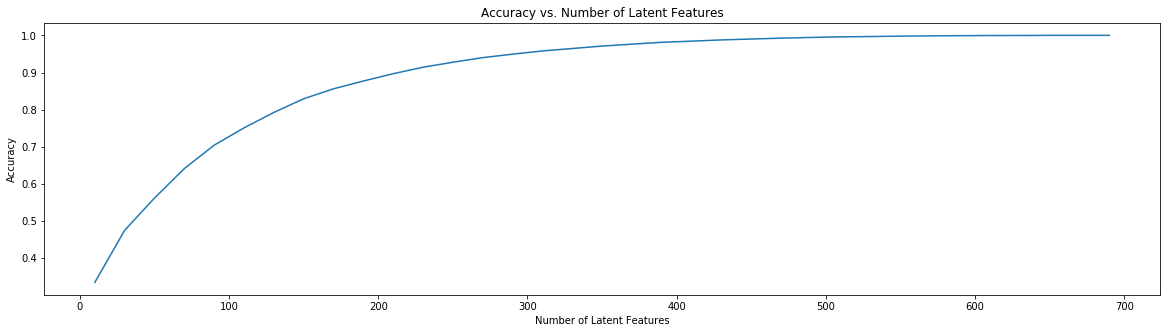

In [362]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [372]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user_item matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Find ids of users from the test set
    test_idx = user_item_test.index.values
    
    # Find article ids from the test set
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [375]:
# How many users can we make predictions for in the test set?
train_idx = user_item_train.index.values
len(np.intersect1d(train_idx, test_idx))

20

In [376]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(test_idx) - len(np.intersect1d(train_idx, test_idx))

662

In [377]:
# How many articles can we make predictions for in the test set?
train_arts = user_item_train.columns.values
len(np.intersect1d(train_arts, test_arts))

574

In [378]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(test_arts) - len(np.intersect1d(train_arts, test_arts))

0

In [382]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [418]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

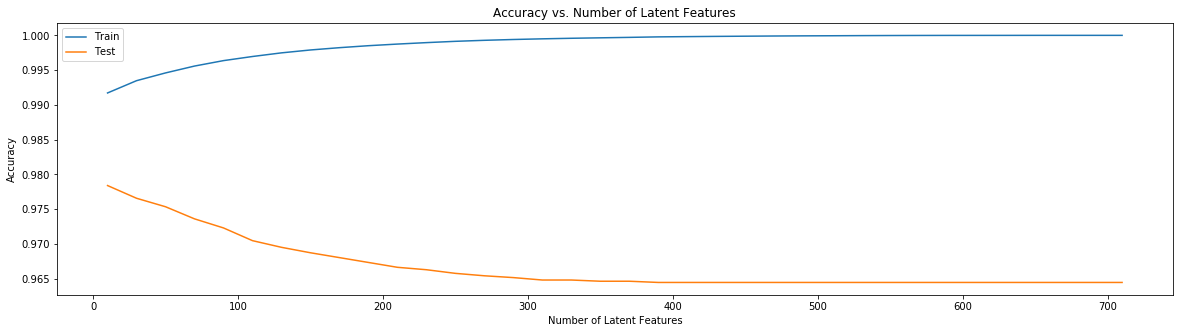

In [439]:
# ids of users we can make predictions for
common_users = np.intersect1d(train_idx, test_idx)

# article_ids of articles we can make preditions for
common_articles = np.intersect1d(train_arts, test_arts)

# subset user_item_test to check predictions for common users and common articles on test data
test_common = user_item_test.loc[common_users.tolist(), common_articles.tolist()]

# subset of u matrix for users we can make predictions for (reduce u rows only for overlapping users)
u_train_common = u_train[user_item_train.index.isin(test_idx), :]

# subset of articles we can make predictions for (reduce vt columns to overlapping articles)
vt_train_common = vt_train[:, user_item_train.columns.isin(test_arts)]

# iterate through range of latent features
num_latent_feats = np.arange(10,700+20,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure train set with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
     
    # restructure matrices for test set with k latent features
    s_test_new, u_test_new, vt_test_new = np.diag(s_train[:k]), u_train_common[:, :k], vt_train_common[:k, :]
    
    # take dot product to make predictions on test and on train data
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(test_common, user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
# plot test and train error
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_train.shape[1]), label = 'Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(test_common.shape[0] * test_common.shape[1]), label = 'Test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

`6.1 Results Summary:` Regarding the train and test accuracy plotted on graph above, it makes sense to keep about 20 latent features based on the accuracy on test data (20 latent features give about 0.976% accuracy on test dataset). However having this level of accuracy on test data doesn't really mean that we make good predictions. It seems that this level of accuracy is acheived because there are a lot of 0s in matrix (see calculations below: all zero predictions give about 98% accuracy), so we are good at predicting 0s, but not at making recommendations for articles which user should view.

In [445]:
# accuracy given by all zero matrix as prediction

diffs = np.subtract(test_common, np.zeros(user_item_est_test.shape))
errs = np.sum(np.sum(np.abs(diffs)))
1 - errs/(test_common.shape[0] * test_common.shape[1])

0.9810104529616724

In [438]:
1 - np.array(sum_errs_test)/(test_common.shape[0] * test_common.shape[1])

array([0.97839721, 0.97656794, 0.97534843, 0.97360627, 0.97229965,
       0.97047038, 0.9695122 , 0.96872822, 0.96803136, 0.96733449,
       0.96663763, 0.9662892 , 0.96576655, 0.96541812, 0.96515679,
       0.96480836, 0.96480836, 0.96463415, 0.96463415, 0.96445993,
       0.96445993, 0.96445993, 0.96445993, 0.96445993, 0.96445993,
       0.96445993, 0.96445993, 0.96445993, 0.96445993, 0.96445993,
       0.96445993, 0.96445993, 0.96445993, 0.96445993, 0.96445993,
       0.96445993])

`6.2 How to test how well recommendation engine is working in practice:` To test how well recommendation engine is working on practice I suggest to perform A/B testing.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [728]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0